# Imports 

In [2]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [3]:
xgb.__version__

'0.90'

In [40]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20191218/'

os.system("mkdir -p "+ plotDir)
os.system("mkdir -p "+ plotDir + "training")
os.system("mkdir -p "+ plotDir + "results")
os.system("mkdir -p "+ plotDir + "scores")
os.system("mkdir -p "+ plotDir + "variables")

0

In [7]:
# signal and bkg file normalized
dataDir = '/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/llp_analyzer/skimmed/'
#sig 
signalFileName = dataDir + 'out_sig.root'
# signalFileName = dataDir + 'bdt_hh_sig.root'
signalFile = rt.TFile(signalFileName)
signalTree = signalFile.Get('SusyLLPTree')
signalEvents = lumi_sf_sig*signalTree.GetEntries()

#bkg
bkgFileName    = dataDir + 'out_bkg.root'
# bkgFileName    = dataDir + 'bdt_qcd_bkg.root'
bkgFile = rt.TFile(bkgFileName)
bkgTree = bkgFile.Get('SusyLLPTree')
bkgEvents = lumi_sf_bkg*bkgTree.GetEntries()

# print('[INFO]: S =' + str(signalEvents) + '; B =' + str(bkgEvents) +"; S/sqrt(B) = " + str(signalEvents/math.sqrt(bkgEvents)))

In [8]:
## print check
root_dir = uproot.open(signalFileName) 
tree = root_dir['SusyLLPTree']
jet_amax = tree['jetGammaMax_ET'].array()
print(jet_amax[:10])
jet_amax = tree['jetTime'].array()
print(jet_amax[:10])
jet_amax = tree['jetChargedHadronEnergyFraction'].array()
print(jet_amax[:10])
jet_amax = tree['jetMinDeltaRPVTracks'].array()
print(jet_amax[:10])
jet_amax = tree['jet_sig_et1'].array()
print(jet_amax[:10])
jet_amax = tree['jet_sig_et2'].array()
print(jet_amax[:10])
jet_amax = tree['jetPt'].array()
print(jet_amax[:10])
jet_amax = tree['jetTime'].array()
print(jet_amax[:10])
jet_amax = tree['weight'].array()
print(jet_amax[:10])
jet_amax = tree['flat_w'].array()
print(jet_amax[:10])


[[0.8213783 0.09114762 0.022484139 ... 0.04815962 0.045498878 0.05268602] [0.17097482 0.0 0.04296285] [0.7345806 0.011087919 0.05050978] ... [0.80381083 0.030696455 0.5629636 0.45533514] [0.0064908816 0.046800405] [0.025235731 0.39323655 0.46632805 0.019471107]]
[[0.45468906 0.018546667 -0.0021034658 ... 0.823035 1.8102738 0.8056404] [-0.19918905 0.3974986 2.0107133] [0.6946223 0.9554211 nan] ... [0.047974285 nan 0.93899477 nan] [0.41254196 0.24762432] [-2.5595973 -0.051360894 0.98467463 nan]]
[[0.8743499 0.12697504 0.41022068 ... 0.074458055 0.6847254 0.3480896] [0.3511741 0.21628588 0.58574754] [0.74335617 0.021333866 0.07827084] ... [0.8593344 0.14179981 0.5942389 1.0000001] [0.016421976 0.25067148] [0.02045011 0.47924685 0.6985029 0.056819018]]
[[0.0071905884 0.055050187 0.2653137 ... 0.2254032 0.28217614 0.20220307] [0.05586406 0.53770095 0.23880224] [0.024409927 0.24661335 0.1363337] ... [0.022889229 0.32827422 0.05095361 0.17917608] [0.20178808 0.05935885] [0.34917346 0.05619510

In [56]:
## print check bkg
root_dir = uproot.open(bkgFileName) 
tree = root_dir['SusyLLPTree']
# jet_amax = tree['jetGammaMax_ET'].array()
# print(jet_amax[:10])
# jet_amax = tree['jetTime'].array()
# print(jet_amax[:10])
# jet_amax = tree['jetChargedHadronEnergyFraction'].array()
# print(jet_amax[:10])
# jet_amax = tree['jetMinDeltaRPVTracks'].array()
# print(jet_amax[:10])
# jet_amax = tree['jet_sig_et1'].array()
# print(jet_amax[:10])
# jet_amax = tree['jet_sig_et2'].array()
# print(jet_amax[:10])
# jet_amax = tree['jetPt'].array()
# print(len(jet_amax))
# print(jet_amax[:10])
# jet_amax = tree['jetTime'].array()
# print(len(jet_amax[0]))
# print(len(jet_amax))
# print(jet_amax[:10])
jet_amax = tree['weight'].array()
print(jet_amax[:10])
print(np.unique(jet_amax))
print(len(jet_amax[jet_amax==6.3736355e-03]))
print(len(jet_amax[jet_amax==3.2551792e-02]))
# jet_amax = tree['flat_w'].array()
# print(jet_amax[:10])
# print(len(jet_amax))
# print(len(jet_amax[0]))


[8.14933e-05 8.14933e-05 8.14933e-05 8.14933e-05 8.14933e-05 8.14933e-05
 8.14933e-05 8.14933e-05 8.14933e-05 8.14933e-05]
[4.2763832e-06 1.0382146e-05 8.1493301e-05 1.7900382e-04 5.5480335e-04
 6.3736355e-03 3.2551792e-02]
38
2


In [74]:
#variables
variables = [
#         ['met', 'met', 'met', 100, 0, 1000],
#         ['jetPt', 'jetPt', 'jetPt', 50, 0, 1000],
        ['jetTime', 'jetTime', 'jetTime', 50, -10, 20],
        ['jetChargedHadronEnergyFraction', 'jetChargedHadronEnergyFraction', 'CHEF', 50, 0, 1],
        ['jetGammaMax_ET', 'jetGammaMax_ET', 'jetGammaMax_ET', 50, 0, 1],
        ['jetMinDeltaRPVTracks', 'jetMinDeltaRPVTracks', 'jetMinDeltaRPVTracks', 50, 0, 1],
#         ['jet_sig_et1', 'jet_sig_et1', 'jet_sig_et1', 50, 0, 0.3],
#         ['jet_sig_et1', 'jet_sig_et2', 'jet_sig_et2', 50, 0, 0.3],
            ]


In [75]:
##Getting ROOT files into pandas
df_signal = uproot.open(signalFileName)['SusyLLPTree'].pandas.df([row[0] for row in variables], flatten=True)
df_bkg = uproot.open(bkgFileName)['SusyLLPTree'].pandas.df([row[0] for row in variables], flatten=True)


In [76]:
#weight
#sig
sig_root_dir = uproot.open(signalFileName) 
sig_tree = sig_root_dir['SusyLLPTree']
# #branches
sig_w = sig_tree['weight'].array() 
sig_jet_pt = sig_tree['jetPt'].array()
from itertools import chain 
sig_flat_w = [np.array([x]*len(y)) for x,y in zip(sig_w,sig_jet_pt)]
sig_flat_w = list(chain.from_iterable(sig_flat_w))
sig_flat_w = [x*137000 for x in sig_flat_w]
# sig_w = sig_tree['flat_w'].array().flatten()
# bkg
bkg_root_dir = uproot.open(bkgFileName) 
bkg_tree = bkg_root_dir['SusyLLPTree']
# #branches
bkg_w = bkg_tree['weight'].array() 
bkg_jet_pt = bkg_tree['jetPt'].array()
bkg_flat_w = [np.array([x]*len(y)) for x,y in zip(bkg_w,bkg_jet_pt)]
bkg_flat_w = list(chain.from_iterable(bkg_flat_w)) 
bkg_flat_w = [x*137000 for x in bkg_flat_w]
# bkg_w = bkg_tree['flat_w'].array().flatten()
# sample weight
sample_w = np.concatenate([sig_flat_w,bkg_flat_w])
# sample_w = np.concatenate([sig_w,bkg_w])
print(sig_flat_w[0])
print(())
print(len(sig_flat_w))
print(len(sig_w))
print(len(sig_jet_pt))
print(len(sig_jet_pt.flatten()))


1.1118959409941453
()
31108
8774
8774
31108


In [77]:
# #remake new sig root file
# sig_root_dir = uproot.open(signalFileName) 
# sig_tree = sig_root_dir['SusyLLPTree']
# #branches
# sig_w = sig_tree['weight'].array()
# sig_jet_pt = sig_tree['jetPt'].array()
# sig_jet_t = sig_tree['jetTime'].array()
# sig_jet_chef = sig_tree['jetChargedHadronEnergyFraction'].array()
# sig_jet_tmf = sig_tree['jetGammaMax_ET'].array()
# sig_jet_dr = sig_tree['jetMinDeltaRPVTracks'].array()
# #flatten
# from itertools import chain 
# sig_flat_w = [np.array([x]*len(y)) for x,y in zip(sig_w,sig_jet_pt)]
# sig_flat_w = list(chain.from_iterable(sig_flat_w)) 
# sig_flat_pt = list(chain.from_iterable(sig_jet_pt)) 
# sig_flat_t = list(chain.from_iterable(sig_jet_t)) 
# sig_flat_chef = list(chain.from_iterable(sig_jet_chef)) 
# sig_flat_tmf = list(chain.from_iterable(sig_jet_tmf)) 
# sig_flat_dr = list(chain.from_iterable(sig_jet_dr)) 
# #new tree
# # print(len(sig_w))
# # print(len(sig_jet_t))
# # print(len(sig_jet_t.flatten()))
# # print(len(sig_flat_w))
# # print(len(sig_flat_t))
# # print(type(sig_flat_w))
# # print(type(sig_flat_t))
# # print(type(sig_flat_pt))
# # print(type(np.array(sig_flat_pt)))
# new_sig_tree_array = np.stack((sig_flat_w,sig_flat_pt,sig_flat_t,sig_flat_chef,sig_flat_tmf,sig_flat_dr),axis=-1)
# # print(type(new_sig_tree_array))
# # print(new_sig_tree_array[0])
# # print(type(new_sig_tree_array[0]))

# # print(sig_flat_w[0])
# # print(sig_flat_t[0])
# # print(type(new_sig_tree_array))
# # print(len(new_sig_tree_array))
# # print(len(new_sig_tree_array[0]))
# # print(new_sig_tree_array[0])

# h_new_sig_tree_array = [np.array(x) for x in new_sig_tree_array]
# print(type(h_new_sig_tree_array))
# print(len(h_new_sig_tree_array))
# print(len(h_new_sig_tree_array[0]))
# print(h_new_sig_tree_array[0])


# h_new_sig_tree_array = np.array(h_new_sig_tree_array,
# # h_new_sig_tree_array = np.array([np.array(sig_flat_w),np.array(sig_flat_pt),np.array(sig_flat_t),np.array(sig_flat_chef),np.array(sig_flat_tmf),np.array(sig_flat_dr)], 
#                               dtype=[('weight', np.float32),
#                                      ('jetPt', np.float32),
#                                      ('jetTime', np.float32),
#                                      ('jetChargedHadronEnergyFraction', np.float32),
#                                      ('jetGammaMax_ET', np.float32),
#                                      ('jetMinDeltaRPVTracks', np.float32),
#                                     ]
#                                )

# print(type(h_new_sig_tree_array))
# print(len(h_new_sig_tree_array))
# print(len(h_new_sig_tree_array[0]))
# print(h_new_sig_tree_array[0])

# # from root_numpy import array2root, root2array, array2tree
# # new_sig = array2root(new_tree_array, 'new_sig.root', new_sig_tree, mode='recreate') 
# # import root_numpy as rtnp
# new_sig_tree = array2tree(h_new_sig_tree_array)
# new_sig_tree.Scan()

In [78]:
# from root_numpy import array2tree
# import numpy as np
# a = np.array([(1, 2.5, 3.4),
#                (4, 5, 6.8)],
#               dtype=[('a', np.int32),
#                      ('b', np.float32),
#                      ('c', np.float64)])
# print(a)
# print(type(a))
# print(a[0])
# print(type(a[0]))
# a_tree = array2tree(a)
# a_tree.Scan()

In [79]:
# #remake new bkg root file
# bkg_root_dir = uproot.open(bkgFileName) 
# bkg_tree = bkg_root_dir['SusyLLPTree']
# #branches
# bkg_w = bkg_tree['weight'].array()
# bkg_jet_pt = bkg_tree['jetPt'].array()
# bkg_jet_t = bkg_tree['jetTime'].array()
# bkg_jet_chef = bkg_tree['jetChargedHadronEnergyFraction'].array()
# bkg_jet_tmf = bkg_tree['jetGammaMax_ET'].array()
# bkg_jet_dr = bkg_tree['jetMinDeltaRPVTracks'].array()
# #flatten
# from itertools import chain 
# bkg_flat_w = [np.array([x]*len(y)) for x,y in zip(bkg_w,bkg_jet_pt)]
# bkg_flat_w = list(chain.from_iterable(bkg_flat_w)) 
# bkg_flat_pt = list(chain.from_iterable(bkg_jet_pt)) 
# bkg_flat_t = list(chain.from_iterable(bkg_jet_t)) 
# bkg_flat_chef = list(chain.from_iterable(bkg_jet_chef)) 
# bkg_flat_tmf = list(chain.from_iterable(bkg_jet_tmf)) 
# bkg_flat_dr = list(chain.from_iterable(bkg_jet_dr)) 
# #new tree
# print(len(bkg_w))
# print(len(bkg_jet_t))
# print(len(bkg_jet_t.flatten()))
# print(len(bkg_flat_w))
# print(len(bkg_flat_t))
# new_bkg_tree_array = np.stack((bkg_flat_w,bkg_flat_pt,bkg_flat_t,bkg_flat_chef,bkg_flat_tmf,bkg_flat_dr),axis=-1)

# print(bkg_flat_w[0])
# print(bkg_flat_t[0])
# print(len(new_bkg_tree_array))
# print(len(new_bkg_tree_array[0]))
# print(new_bkg_tree_array[0])

In [80]:
## change nan to -999
df_signal = df_signal.fillna(-999)
df_bkg = df_bkg.fillna(-999)


In [81]:
# ##Getting NEW ARRAY files into pandas
# df_signal = uproot.open(signalFileName)['SusyLLPTree'].pandas.df([row[0] for row in variables], flatten=True)
# df_bkg = uproot.open(bkgFileName)['SusyLLPTree'].pandas.df([row[0] for row in variables], flatten=True)

In [82]:
##Getting a numpy array out of two pandas data frame

#getting a numpy array from two pandas data frames
x = np.concatenate([df_bkg.values,df_signal.values])
#creating numpy array for target variables
y = np.concatenate([np.zeros(len(df_bkg)),
np.ones(len(df_signal))])

In [83]:
###plot correlation
file_sig = rt.TFile(signalFileName)
tree_sig = file_sig.Get("SusyLLPTree")
file_bkg = rt.TFile(bkgFileName)
tree_bkg = file_sig.Get("SusyLLPTree")
h2_corr_sig = rt.TH2F("h2_corr_sig", "h2_corr_sig", len(variables), 0, len(variables), len(variables), 0, len(variables))
h2_corr_bkg = rt.TH2F("h2_corr_bkg", "h2_corr_bkg", len(variables), 0, len(variables), len(variables), 0, len(variables))

for idx1 in range(len(variables)):
        for idx2 in range(len(variables)):
                tree_sig.Draw(variables[idx1][0]+":"+variables[idx2][0]+">>temp_sig")
                tree_bkg.Draw(variables[idx1][0]+":"+variables[idx2][0]+">>temp_bkg")
                sig_hist = rt.gDirectory.Get('temp_sig')
                h2_corr_sig.SetBinContent(idx1+1, idx2+1, sig_hist.GetCorrelationFactor())
                bkg_hist = rt.gDirectory.Get('temp_bkg')
                h2_corr_bkg.SetBinContent(idx1+1, idx2+1, bkg_hist.GetCorrelationFactor())
                rt.gDirectory.Delete('temp_sig')
                rt.gDirectory.Delete('temp_bkg')
h2_corr_sig.GetXaxis().SetLabelSize(0.03)
h2_corr_sig.GetYaxis().SetLabelSize(0.03)
h2_corr_sig.GetZaxis().SetLabelSize(0.03)
h2_corr_bkg.GetXaxis().SetLabelSize(0.03)
h2_corr_bkg.GetYaxis().SetLabelSize(0.03)
h2_corr_bkg.GetZaxis().SetLabelSize(0.03)
h2_corr_sig.GetZaxis().SetRangeUser(-1.0, 1.0)
h2_corr_bkg.GetZaxis().SetRangeUser(-1.0, 1.0)
for idx in range(len(variables)):
        h2_corr_sig.GetXaxis().SetBinLabel(idx+1, variables[idx][1])
        h2_corr_sig.GetYaxis().SetBinLabel(idx+1, variables[idx][1])
        h2_corr_bkg.GetXaxis().SetBinLabel(idx+1, variables[idx][1])
        h2_corr_bkg.GetYaxis().SetBinLabel(idx+1, variables[idx][1])

myC = rt.TCanvas( "myC", "myC", 200, 10, 900, 800 )
myC.SetHighLightColor(2)
myC.SetFillColor(0)
myC.SetBorderMode(0)
myC.SetBorderSize(2)
myC.SetLeftMargin( 0.12 )
myC.SetRightMargin( 0.12 )
myC.SetBottomMargin( 0.12 )
myC.SetTopMargin( 0.12 )
myC.SetFrameBorderMode(0)
myC.SetFrameBorderMode(0)

stops = np.array([0.00, 0.34, 0.61, 0.84, 1.00])
red= np.array([0.50, 0.50, 1.00, 1.00, 1.00])
green = np.array([ 0.50, 1.00, 1.00, 0.60, 0.50])
blue = np.array([1.00, 1.00, 0.50, 0.40, 0.50])
rt.TColor.CreateGradientColorTable(len(stops), stops, red, green, blue, 255)
rt.gStyle.SetNumberContours(255)



h2_corr_sig.Draw("COLZTEXT")
h2_corr_sig.SetTitle("")
myC.SaveAs(plotDir+'variables/'+test_name + '_correlation_matrix_sig.pdf')
myC.SaveAs(plotDir+'variables/'+test_name + '_correlation_matrix_sig.png')
myC.SaveAs(plotDir+'variables/'+test_name + '_correlation_matrix_sig.C')
h2_corr_bkg.Draw("COLZTEXT")
h2_corr_bkg.SetTitle("")
myC.SaveAs(plotDir+'variables/'+test_name + '_correlation_matrix_bkg.pdf')
myC.SaveAs(plotDir+'variables/'+test_name + '_correlation_matrix_bkg.png')
myC.SaveAs(plotDir+'variables/'+test_name + '_correlation_matrix_bkg.C')
os.system("chmod 755 "+plotDir+"variables/*")


0

Warning in <TCanvas::Constructor>: Deleting canvas with same name: myC
Info in <TCanvas::Print>: pdf file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191218/variables/xgb_HH_vs_QCD_ebBDT_correlation_matrix_sig.pdf has been created
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191218/variables/xgb_HH_vs_QCD_ebBDT_correlation_matrix_sig.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/jmao/gpu/jmao/cms-llp/plots/20191218/variables/xgb_HH_vs_QCD_ebBDT_correlation_matrix_sig.C has been generated
Info in <TCanvas::Print>: pdf file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191218/variables/xgb_HH_vs_QCD_ebBDT_correlation_matrix_bkg.pdf has been created
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191218/variables/xgb_HH_vs_QCD_ebBDT_correlation_matrix_bkg.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/jmao/gpu/jmao/cms-llp/plots/20191218/variables/xgb_HH_vs

In [84]:
####Print input variables######
for idx in range(len(variables)):
    print(idx, variables[idx][0])
    print(df_signal[df_signal[variables[idx][0]]>0][variables[idx][0]][:10])


0 jetTime
entry  subentry
0      0           0.454689
       1           0.018547
       4           0.823035
       5           1.810274
       6           0.805640
1      1           0.397499
       2           2.010713
2      0           0.694622
       1           0.955421
3      3           0.665251
Name: jetTime, dtype: float32
1 jetChargedHadronEnergyFraction
entry  subentry
0      0           0.874350
       1           0.126975
       2           0.410221
       3           0.856644
       4           0.074458
       5           0.684725
       6           0.348090
1      0           0.351174
       1           0.216286
       2           0.585748
Name: jetChargedHadronEnergyFraction, dtype: float32
2 jetGammaMax_ET
entry  subentry
0      0           0.821378
       1           0.091148
       2           0.022484
       3           0.122118
       4           0.048160
       5           0.045499
       6           0.052686
1      0           0.170975
       2           0.0429

0

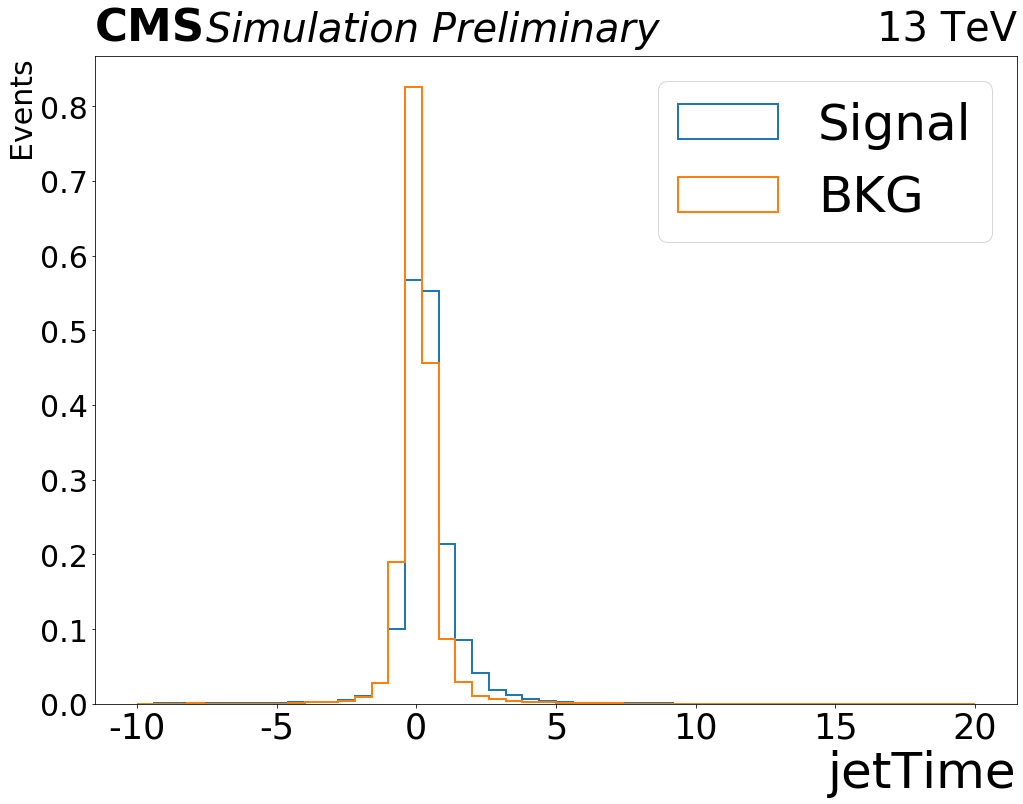

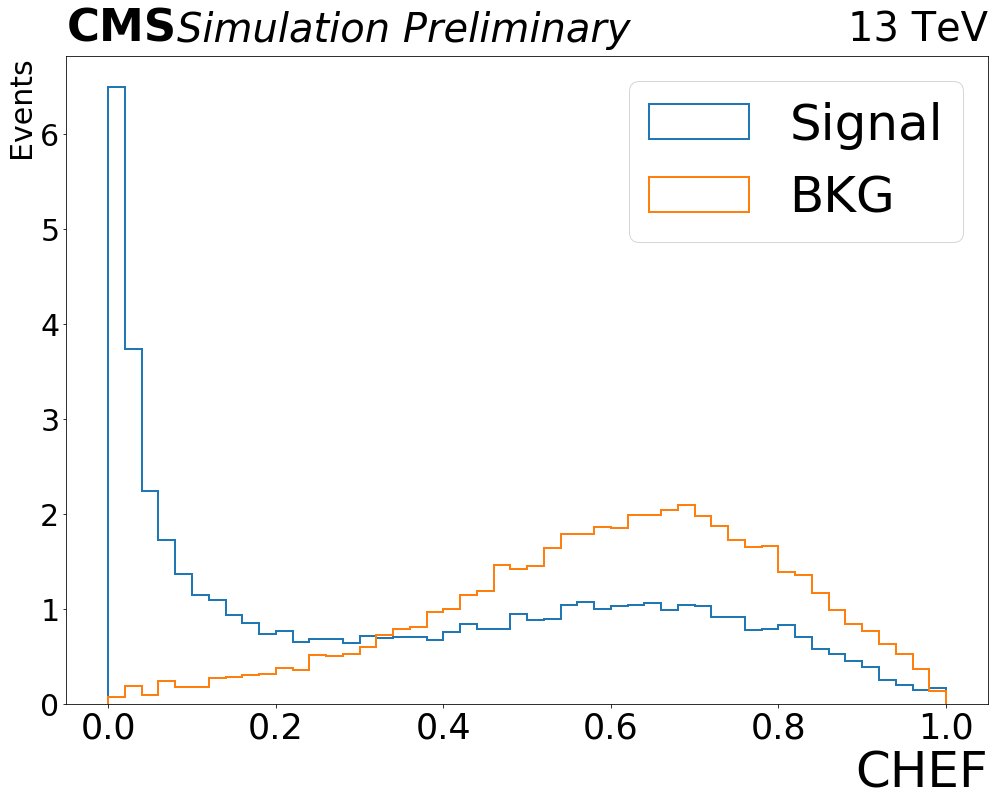

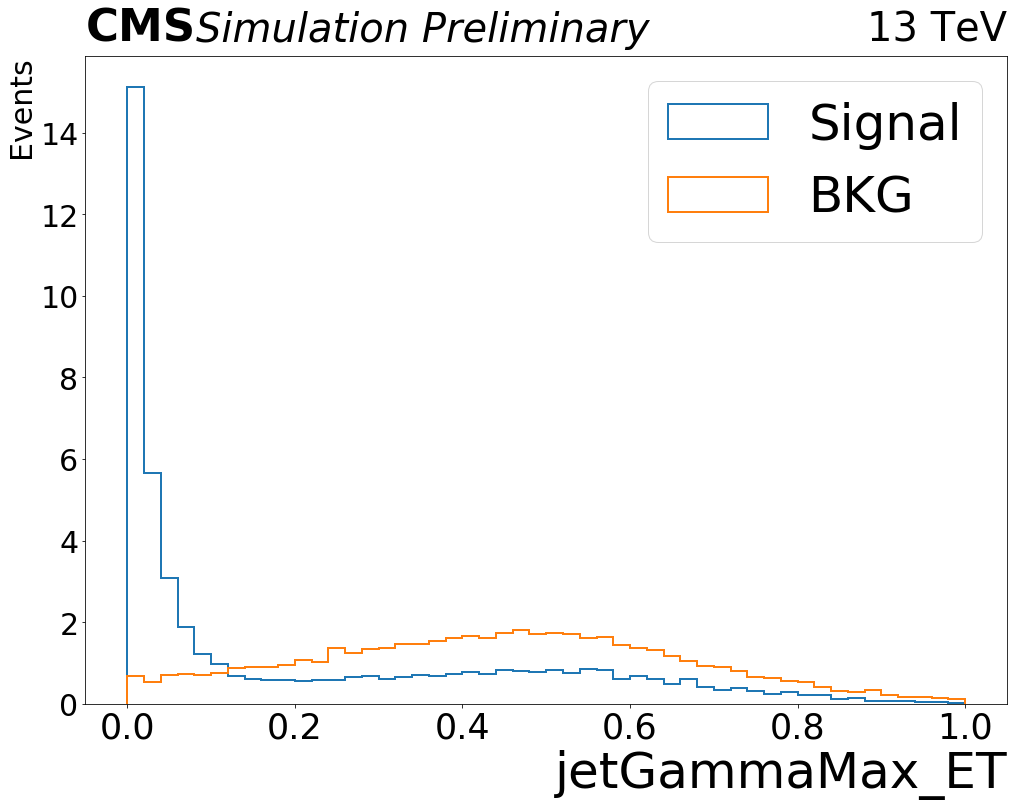

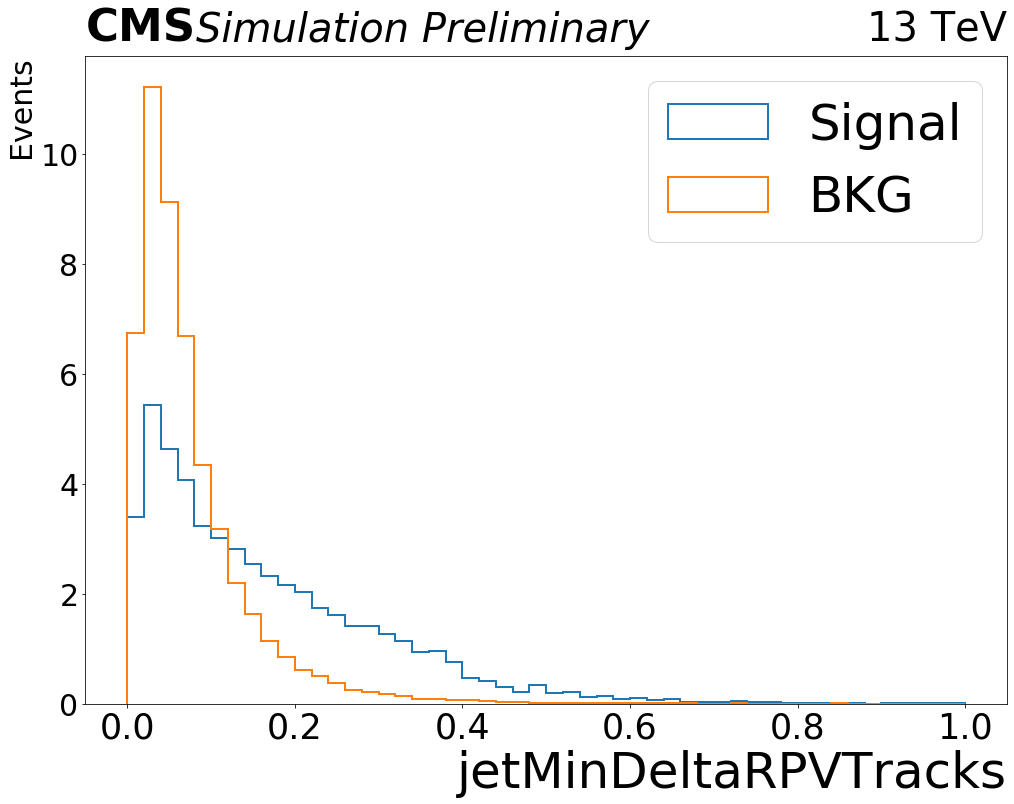

In [85]:
####Plot input variables######
for idx in range(len(variables)):
        f = plt.figure()
        ax = f.add_subplot(111)
        plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
        
#         plt.hist(df_signal[df_signal[variables[idx][0]] > -999][variables[idx][0]], density=True, alpha=1.0, histtype="step", lw=2, label="Signal", bins=variables[idx][3], range=(variables[idx][4], variables[idx][5]), weights=sig_flat_w)
#         plt.hist(df_bkg[df_bkg[variables[idx][0]] > -999][variables[idx][0]], density=True, alpha=1.0, histtype="step", lw=2, label="BKG", bins=variables[idx][3], range=(variables[idx][4], variables[idx][5]),weights=bkg_flat_w)
        plt.hist(df_signal[variables[idx][0]], density=True, alpha=1.0, histtype="step", lw=2, label="Signal", bins=variables[idx][3], range=(variables[idx][4], variables[idx][5]), weights=sig_flat_w)
        plt.hist(df_bkg[variables[idx][0]], density=True, alpha=1.0, histtype="step", lw=2, label="BKG", bins=variables[idx][3], range=(variables[idx][4], variables[idx][5]),weights=bkg_flat_w)

#         if variables[idx][0]=='met':
#             plt.hist(df_signal[df_signal[variables[idx][0]] > -999][variables[idx][0]], density=True, alpha=1.0, histtype="step", lw=2, label="Signal", bins=variables[idx][3], range=(variables[idx][4], variables[idx][5]))
#             plt.hist(df_bkg[df_bkg[variables[idx][0]] > -999][variables[idx][0]], density=True, alpha=1.0, histtype="step", lw=2, label="BKG", bins=variables[idx][3], range=(variables[idx][4], variables[idx][5]))
#         else:
#             plt.hist(np.array(df_signal[df_signal[variables[idx][0]] > -999][variables[idx][0]]).flatten(), density=True, alpha=1.0, histtype="step", lw=2, label="Signal", bins=variables[idx][3], range=(variables[idx][4], variables[idx][5]))
#             plt.hist(np.array(df_bkg[df_bkg[variables[idx][0]] > -999][variables[idx][0]]).flatten(), density=True, alpha=1.0, histtype="step", lw=2, label="BKG", bins=variables[idx][3], range=(variables[idx][4], variables[idx][5]))
            
        plt.legend(loc="upper right", fontsize = 50)
        plt.xlabel(variables[idx][2], fontsize=50,horizontalalignment='right', x=1.0)
        plt.ylabel('Events', fontsize=30,horizontalalignment='right', y=1.0)
        plt.xticks(fontsize=35)
        plt.yticks(fontsize=30)
        fig = plt.gcf()
        fig.set_size_inches(16, 12)
        plt.text(0.0, 1.01, "CMS", ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=45)
        plt.text(0.12, 1.01, "Simulation Preliminary", ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=40)
        plt.text(1.0, 1.01, "13 TeV", ha='right', va='bottom', transform=ax.transAxes, fontsize=40)
        plt.draw()
#         plt.savefig(plotDir+'variables/'+test_name + '_' + variables[idx][0]+'.pdf')#, bbox_inches='tight')
#         plt.savefig(plotDir+'variables/'+test_name + '_' + variables[idx][0]+'.png')#, bbox_inches='tight')
        plt.savefig(plotDir+'variables/'+test_name + '_' + variables[idx][0]+'.png', facecolor='w', transparent=False)#, bbox_inches='tight')
#         plt.savefig(plotDir+'variables/'+test_name + '_' + variables[idx][0]+'.eps')#, bbox_inches='tight')


os.system("chmod 755 "+plotDir+"variables/*")

In [86]:
# split data into train and test sets
seed = 7
test_size = 0.4
sample_size = 1.0
x_train, x_test, y_train, y_test, w_train, w_test = train_test_split(x, y, sample_w, train_size = sample_size*(1-test_size), test_size=sample_size*test_size, random_state=seed)

# fit model no training data
model = xgb.XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=400, verbosity=2, n_jobs=4, reg_lambda=1.0)
# model.fit(x_train, y_train)
model.fit(x_train, y_train, sample_weight=w_train)
# model.fit(x_train, y_train, sample_weight=sample_w)

#print( dir(model) )
#print(model)
# make predictions for test data
y_pred = model.predict_proba(x_test)[:, 1]
y_pred_train = model.predict_proba(x_train)[:, 1]
y_pred_bkg = model.predict_proba(df_bkg.values)[:, 1]
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

AUC = roc_auc_score(y_test, y_pred)
print("AUC: "+str(AUC))
#get roc curve
#roc = roc_curve(y_test, y_pred)
fpr, tpr, thr = roc_curve(y_test, y_pred)


significance = []
effSignal = []
effBkg = []
thresholds = []

ctr = 0
for i in range(len(fpr)):
    if fpr[i] > 1e-5 and tpr[i] > 1e-5:
        print("thr = "+str(thr[i])+", fpr = "+str(fpr[i]) + ", tpr = "+str(tpr[i]))
        #print fpr[i], tpr[i] 
        #significance.append(math.sqrt(lumi)*4.8742592356*0.006431528796*tpr[i]/math.sqrt(fpr[i]*0.9935684712))
        significance.append(signalEvents*tpr[i]/math.sqrt(fpr[i]*bkgEvents))
        effSignal.append(tpr[i])
        effBkg.append(fpr[i])
        thresholds.append(thr[i])
        #print significance[ctr], ' ' , fpr[ctr], ' ', tpr[ctr]
        ctr = ctr + 1


max_significance = max(significance)
idx_max_significance = np.argmax(np.array(significance))
best_threshold = thresholds[idx_max_significance]
best_effSignal = effSignal[idx_max_significance]
best_effBkg = effBkg[idx_max_significance]

print("max_significance: "+str(max_significance))
print("best_threshold: "+str(best_threshold))
print("best_effSignal: "+str(best_effSignal))
print("best_effBkg: "+str(best_effBkg))

idx_WP90 = 0
minD0p9 = 999.0
for idx in range(len(effSignal)):
	if abs(effSignal[idx] - 0.90) < minD0p9:
		idx_WP90 = idx
		minD0p9 = abs(effSignal[idx] - 0.90)

WP90_significance = significance[idx_WP90]
WP90_threshold = thresholds[idx_WP90]
WP90_effSignal = effSignal[idx_WP90]
WP90_effBkg = effBkg[idx_WP90]

print("WP90_significance: "+str(WP90_significance))
print("WP90_threshold: "+str(WP90_threshold))
print("WP90_effSignal: "+str(WP90_effSignal))
print("WP90_effBkg: "+str(WP90_effBkg))

idx_WP80 = 0
minD0p8 = 999.0
for idx in range(len(effSignal)):
        if abs(effSignal[idx] - 0.80) < minD0p8:
                idx_WP80 = idx
                minD0p8 = abs(effSignal[idx] - 0.80)

WP80_significance = significance[idx_WP80]
WP80_threshold = thresholds[idx_WP80]
WP80_effSignal = effSignal[idx_WP80]
WP80_effBkg = effBkg[idx_WP80]

print("WP80_significance: "+str(WP80_significance))
print("WP80_threshold: "+str(WP80_threshold))
print("WP80_effSignal: "+str(WP80_effSignal))
print("WP80_effBkg: "+str(WP80_effBkg))

idx_WP50 = 0
minD0p5 = 999.0
for idx in range(len(effSignal)):
        if abs(effSignal[idx] - 0.50) < minD0p5:
                idx_WP50 = idx
                minD0p5 = abs(effSignal[idx] - 0.50)

WP50_significance = significance[idx_WP50]
WP50_threshold = thresholds[idx_WP50]
WP50_effSignal = effSignal[idx_WP50]
WP50_effBkg = effBkg[idx_WP50]

print("WP50_significance: "+str(WP50_significance))
print("WP50_threshold: "+str(WP50_threshold))
print("WP50_effSignal: "+str(WP50_effSignal))
print("WP50_effBkg: "+str(WP50_effBkg))

[18:39:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:39:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:39:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:39:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:39:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:39:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:39:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[18:39:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nod

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


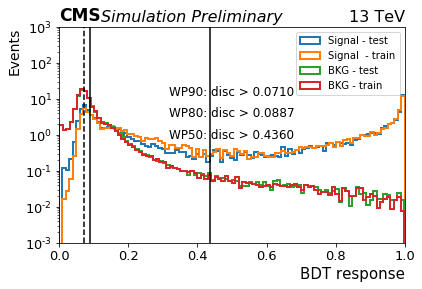

In [87]:
##########################################################
# make histogram of discriminator value for signal and bkg
##########################################################
#pd.DataFrame({'truth':y_test, 'disc':y_pred}).hist(column='disc', by='truth', bins=50)
y_frame = pd.DataFrame({'truth':y_test, 'disc':y_pred})
y_frame_train = pd.DataFrame({'truth':y_train, 'disc':y_pred_train})
disc_bkg    = y_frame[y_frame['truth'] == 0]['disc'].values
disc_bkg_train    = y_frame_train[y_frame_train['truth'] == 0]['disc'].values
disc_signal = y_frame[y_frame['truth'] == 1]['disc'].values
disc_signal_train = y_frame_train[y_frame_train['truth'] == 1]['disc'].values
f = plt.figure()
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
plt.hist(disc_signal, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="Signal - test")
plt.hist(disc_signal_train, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="Signal  - train")
plt.hist(disc_bkg, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="BKG - test")
plt.hist(disc_bkg_train, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="BKG - train")
plt.yscale("log")
plt.xlim([0.0, 1.0])
plt.ylim([0.001, 1000.0])
plt.legend(loc="upper right")
plt.xlabel('BDT response',horizontalalignment='right', x=1.0, fontsize=15)
plt.ylabel('Events',horizontalalignment='right', y=1.0, fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.axvline(x=WP90_threshold, color="black", linestyle='--')
plt.axvline(x=WP80_threshold, color="black")
plt.axvline(x=WP50_threshold, color="black")
plt.text(0.5,0.7,'WP90: disc > %.4f'%WP90_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.text(0.5,0.6,'WP80: disc > %.4f'%WP80_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.text(0.5,0.5,'WP50: disc > %.4f'%WP50_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.text(0.0, 1.01, "CMS", ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
plt.text(0.12, 1.01, "Simulation Preliminary", ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
plt.text(1.0, 1.01, "13 TeV", ha='right', va='bottom', transform=ax.transAxes, fontsize=16)
plt.savefig(plotDir+'training/mydiscriminator_' + test_name +'_logY.pdf')
plt.savefig(plotDir+'training/mydiscriminator_' + test_name +'_logY.png')
plt.savefig(plotDir+'training/mydiscriminator_' + test_name +'_logY.eps')



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0

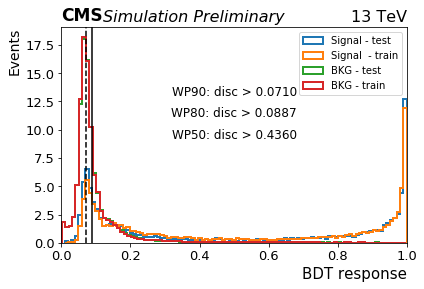

In [88]:
f = plt.figure()
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
plt.hist(disc_signal, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="Signal - test")
plt.hist(disc_signal_train, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="Signal  - train")
plt.hist(disc_bkg, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="BKG - test")
plt.hist(disc_bkg_train, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="BKG - train")
plt.yscale("linear")
plt.xlim([0.0, 1.0])
#plt.ylim([0.001, 100.0])
plt.legend(loc="upper right")
plt.xlabel('BDT response',horizontalalignment='right', x=1.0, fontsize=15)
plt.ylabel('Events',horizontalalignment='right', y=1.0, fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.axvline(x=WP90_threshold, color="black", linestyle='--')
plt.axvline(x=WP80_threshold, color="black")
plt.text(0.5,0.7,'WP90: disc > %.4f'%WP90_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.text(0.5,0.6,'WP80: disc > %.4f'%WP80_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.text(0.5,0.5,'WP50: disc > %.4f'%WP50_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.text(0.0, 1.01, "CMS", ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
plt.text(0.12, 1.01, "Simulation Preliminary", ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
plt.text(1.0, 1.01, "13 TeV", ha='right', va='bottom', transform=ax.transAxes, fontsize=16)
plt.savefig(plotDir+'training/mydiscriminator_' + test_name +'_linY.pdf')
plt.savefig(plotDir+'training/mydiscriminator_' + test_name +'_linY.png')
plt.savefig(plotDir+'training/mydiscriminator_' + test_name +'_linY.eps')


os.system("chmod 755 "+plotDir+"training/*")



0

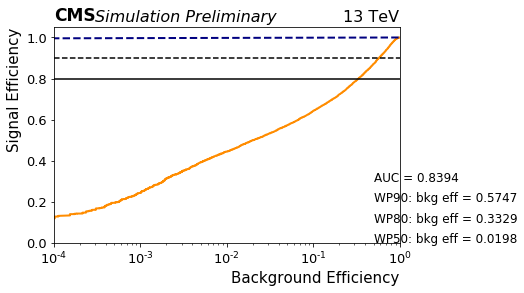

In [89]:
#plot roc curve
f = plt.figure()
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xscale('log')
plt.xlim([0.0001, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('Signal Efficiency',horizontalalignment='right', y=1.0, fontsize=15)
plt.xlabel('Background Efficiency',horizontalalignment='right', x=1.0, fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.axhline(y=0.9, color="black", linestyle='--')
plt.axhline(y=0.8, color="black")
plt.text(0.5,0.0,'WP50: bkg eff = %.4f'%WP50_effBkg, fontsize=12)
plt.text(0.5,0.1,'WP80: bkg eff = %.4f'%WP80_effBkg, fontsize=12)
plt.text(0.5,0.2,'WP90: bkg eff = %.4f'%WP90_effBkg, fontsize=12)
#plt.text(0.5,0.3,'WP90: S/sqrt(B) = %.2f'%WP90_significance, fontsize=12)
plt.text(0.5,0.3,'AUC = %.4f'%AUC, fontsize=12)
#plt.title('Receiver operating characteristic example')
#plt.legend(loc="lower right")
#plt.show()
plt.text(0.0, 1.01, "CMS", ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
plt.text(0.12, 1.01, "Simulation Preliminary", ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
plt.text(1.0, 1.01, "13 TeV", ha='right', va='bottom', transform=ax.transAxes, fontsize=16)
plt.savefig(plotDir+'training/myroc_' + test_name + '.pdf')
plt.savefig(plotDir+'training/myroc_' + test_name + '.png')
plt.savefig(plotDir+'training/myroc_' + test_name + '.eps')
os.system("chmod 755 "+plotDir+"training/*")

In [90]:
# # Pickle dictionary using protocol 0.
# output = open('../models/model_'+test_name+'.pkl', 'wb')
# pickle.dump(model, output)
# output.close()
# model.get_booster().dump_model('../models/model_'+test_name+'.txt')
# model.get_booster().save_model('../models/model_'+test_name+'.xgb')

# print("example input and prediction....")
# print("bkg sample 1st event input:")
# print(df_bkg.values[0])
# print("y_pred_bkg first 20 events")
# print(y_pred_bkg[:20])

0

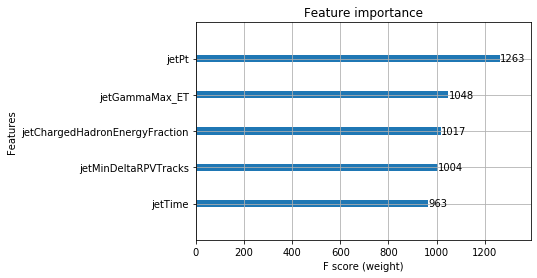

In [53]:
#plot feature importances

model.get_booster().feature_names = [row[1] for row in variables]

xgb.plot_importance(model, max_num_features=len(variables), xlabel="F score (weight)")
plt.savefig(plotDir+'training/myImportances_Fscore_' + test_name + '.pdf', bbox_inches='tight')
plt.savefig(plotDir+'training/myImportances_Fscore_' + test_name + '.png', bbox_inches='tight')
plt.savefig(plotDir+'training/myImportances_Fscore_' + test_name + '.eps', bbox_inches='tight')
os.system("chmod 755 "+plotDir+"training/*")



In [39]:
# #xgb.plot_tree( model.get_booster() )
# xgb.plot_tree( model )
# fig = plt.gcf()
# #fig.set_size_inches(500, 50)
# plt.draw()
# plt.savefig(plotDir+'training/myTree_' + test_name + '.pdf')
# plt.savefig(plotDir+'training/myTree_' + test_name + '.png')
# plt.savefig(plotDir+'training/myTree_' + test_name + '.eps')
# os.system("chmod 755 "+plotDir+"training/*")